# 🏆 Evaluación TSTR: XGBoost-AFT

**Versión:** v3_experimental  
**Rol:** Model Evaluator  
**Fecha:** 2026-01-08

---

## Objetivo

Comparar el rendimiento de XGBoost-AFT (Accelerated Failure Time) entrenado con:
1. **Baseline**: Solo datos reales
2. **Copula**: Real + 100% Sintético (Global)
3. **Advanced**: Real + 100% Sintético (Condicional)

## Metodología: TSTR

**Train on Synthetic, Test on Real**
- Todos los modelos se evalúan en el **mismo Test Set Real**
- XGBoost-AFT usa `y_lower` y `y_upper` para censura

---

In [1]:
# ==============================================================================
# CONFIGURACIÓN Y DEPENDENCIAS
# ==============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
from pathlib import Path
from datetime import datetime

# XGBoost
import xgboost as xgb

# Survival metrics
from sksurv.metrics import concordance_index_censored

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_DIR = Path("../../v2/data/processed")
SYNTH_GLOBAL_PATH = Path("../04_synthetic_sdv/synthetic_data_copula.parquet")
SYNTH_ADVANCED_PATH = Path("../05_synthetic_advanced/synthetic_data_advanced.parquet")
OUTPUT_DIR = Path(".")

print("✅ Dependencias cargadas")
print(f"   Random State: {RANDOM_STATE}")

✅ Dependencias cargadas
   Random State: 42


---
## 1. Carga de Datos

In [2]:
# ==============================================================================
# CARGA DE DATOS
# ==============================================================================

# Datos reales
train_real = pd.read_parquet(DATA_DIR / "train_final.parquet")
test_real = pd.read_parquet(DATA_DIR / "test_final.parquet")

# Datos sintéticos
synth_global = pd.read_parquet(SYNTH_GLOBAL_PATH)
synth_advanced = pd.read_parquet(SYNTH_ADVANCED_PATH)

print(f"📊 Datos cargados:")
print(f"   Train Real:      {train_real.shape}")
print(f"   Test Real:       {test_real.shape}")
print(f"   Synth Global:    {synth_global.shape}")
print(f"   Synth Advanced:  {synth_advanced.shape}")

# Identificar columnas
target_cols = ['duration', 'event']
zero_var_cols = ['tech_python', 'tech_big_data']

# Usar solo columnas comunes
common_cols = list(set(train_real.columns) & set(synth_global.columns) & set(synth_advanced.columns))
feature_cols = [c for c in common_cols if c not in target_cols + zero_var_cols]

print(f"\n   Features comunes: {len(feature_cols)}")

📊 Datos cargados:
   Train Real:      (296, 63)
   Test Real:       (75, 63)
   Synth Global:    (1000, 61)
   Synth Advanced:  (1000, 61)

   Features comunes: 59


---
## 2. Preparar Sets de Entrenamiento

In [3]:
# ==============================================================================
# CREAR 3 SETS DE ENTRENAMIENTO
# ==============================================================================

n_real = len(train_real)

# Set 1: Solo Real (Baseline)
set_baseline = train_real.copy()

# Set 2: Real + Sintético Global (100%)
synth_sample_global = synth_global.sample(n=n_real, random_state=RANDOM_STATE)
set_copula = pd.concat([train_real, synth_sample_global], ignore_index=True)

# Set 3: Real + Sintético Advanced (100%)
synth_sample_advanced = synth_advanced.sample(n=n_real, random_state=RANDOM_STATE)
set_advanced = pd.concat([train_real, synth_sample_advanced], ignore_index=True)

print(f"📊 Sets de Entrenamiento Creados:")
print(f"   Baseline (Real Only):    n={len(set_baseline)}")
print(f"   Copula (Real + Global):  n={len(set_copula)}")
print(f"   Advanced (Real + Cond):  n={len(set_advanced)}")

📊 Sets de Entrenamiento Creados:
   Baseline (Real Only):    n=296
   Copula (Real + Global):  n=592
   Advanced (Real + Cond):  n=592


In [4]:
# ==============================================================================
# PREPARAR DMatrix PARA XGBOOST-AFT
# ==============================================================================

def prepare_xgb_data(df, feature_cols):
    """
    Prepara datos para XGBoost-AFT con y_lower y y_upper.
    - Evento (event=1): y_lower = y_upper = log(duration)
    - Censurado (event=0): y_lower = log(duration), y_upper = +inf
    """
    X = df[feature_cols].values
    duration = df['duration'].values
    event = df['event'].values.astype(bool)
    
    # Log-transform
    y_lower = np.log(duration)
    y_upper = np.where(event, y_lower, np.inf)
    
    # Crear DMatrix
    dmatrix = xgb.DMatrix(X)
    dmatrix.set_float_info('label_lower_bound', y_lower)
    dmatrix.set_float_info('label_upper_bound', y_upper)
    
    return dmatrix, duration, event

# Preparar sets
dtrain_baseline, dur_baseline, evt_baseline = prepare_xgb_data(set_baseline, feature_cols)
dtrain_copula, dur_copula, evt_copula = prepare_xgb_data(set_copula, feature_cols)
dtrain_advanced, dur_advanced, evt_advanced = prepare_xgb_data(set_advanced, feature_cols)

# Preparar test
dtest, dur_test, evt_test = prepare_xgb_data(test_real, feature_cols)

print(f"\n✅ DMatrix preparados:")
print(f"   Baseline: {dtrain_baseline.num_row()} filas")
print(f"   Copula:   {dtrain_copula.num_row()} filas")
print(f"   Advanced: {dtrain_advanced.num_row()} filas")
print(f"   Test:     {dtest.num_row()} filas")


✅ DMatrix preparados:


   Baseline: 296 filas
   Copula:   592 filas
   Advanced: 592 filas
   Test:     75 filas


---
## 3. Entrenar XGBoost-AFT

In [5]:
# ==============================================================================
# ENTRENAR XGBoost-AFT PARA CADA SET
# ==============================================================================

# Parámetros AFT
xgb_params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'max_depth': 3,
    'learning_rate': 0.1,
    'seed': RANDOM_STATE
}
NUM_ROUNDS = 100

results = []

def train_and_evaluate(dtrain, dtest, dur_test, evt_test, scenario_name, n_train, synth_ratio):
    """Entrena XGB-AFT y evalúa."""
    print(f"🚀 Entrenando XGBoost-AFT {scenario_name}...")
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=NUM_ROUNDS,
        evals=[(dtrain, 'train')],
        verbose_eval=False
    )
    
    # Predicción: log-time → invertir para risk
    pred_logtime = model.predict(dtest)
    risk = -pred_logtime  # Mayor riesgo = tiempo más corto
    
    # C-index
    c_index = concordance_index_censored(evt_test, dur_test, risk)[0]
    
    # Log-likelihood aproximada (evaluar en test)
    # Usamos el aft-nloglik del modelo
    evals_result = {}
    xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=NUM_ROUNDS,
        evals=[(dtest, 'test')],
        evals_result=evals_result,
        verbose_eval=False
    )
    final_nloglik = evals_result['test']['aft-nloglik'][-1]
    
    print(f"   C-index: {c_index:.4f}")
    print(f"   -Log-Lik: {final_nloglik:.4f}")
    
    results.append({
        'scenario': scenario_name,
        'n_train': int(n_train),
        'synthetic_ratio': synth_ratio,
        'c_index': float(c_index),
        'neg_loglik': float(final_nloglik)
    })
    
    return model

# --- Modelo 1: Baseline ---
xgb_baseline = train_and_evaluate(
    dtrain_baseline, dtest, dur_test, evt_test,
    'Baseline (Real Only)', len(set_baseline), '0%'
)

# --- Modelo 2: Copula ---
print()
xgb_copula = train_and_evaluate(
    dtrain_copula, dtest, dur_test, evt_test,
    'Real + Copula (100%)', len(set_copula), '100%'
)

# --- Modelo 3: Advanced ---
print()
xgb_advanced = train_and_evaluate(
    dtrain_advanced, dtest, dur_test, evt_test,
    'Real + Advanced (100%)', len(set_advanced), '100%'
)

🚀 Entrenando XGBoost-AFT Baseline (Real Only)...


   C-index: 0.4824
   -Log-Lik: 1.1379

🚀 Entrenando XGBoost-AFT Real + Copula (100%)...


   C-index: 0.4043
   -Log-Lik: 1.1350

🚀 Entrenando XGBoost-AFT Real + Advanced (100%)...
   C-index: 0.4697
   -Log-Lik: 1.1026


---
## 4. Comparación de Resultados

In [6]:
# ==============================================================================
# TABLA DE RESULTADOS
# ==============================================================================

results_df = pd.DataFrame(results)

# Calcular delta vs baseline
baseline_cindex = results_df[results_df['scenario'].str.contains('Baseline')]['c_index'].values[0]
results_df['delta_vs_baseline'] = results_df['c_index'] - baseline_cindex
results_df['improvement'] = results_df['delta_vs_baseline'].apply(
    lambda x: '✅ Mejora' if x > 0.01 else ('⚠️ Similar' if x >= -0.02 else '❌ Peor')
)

print("\n" + "="*80)
print("📊 RESULTADOS XGBoost-AFT - TSTR")
print("="*80)
print(f"\n{results_df.to_string(index=False)}")

# Identificar mejor modelo
best_idx = results_df['c_index'].idxmax()
best_model = results_df.loc[best_idx]

print(f"\n🏆 Mejor Modelo: {best_model['scenario']}")
print(f"   C-index: {best_model['c_index']:.4f}")


📊 RESULTADOS XGBoost-AFT - TSTR

              scenario  n_train synthetic_ratio  c_index  neg_loglik  delta_vs_baseline improvement
  Baseline (Real Only)      296              0% 0.482398    1.137939           0.000000  ⚠️ Similar
  Real + Copula (100%)      592            100% 0.404290    1.134951          -0.078108      ❌ Peor
Real + Advanced (100%)      592            100% 0.469747    1.102644          -0.012651  ⚠️ Similar

🏆 Mejor Modelo: Baseline (Real Only)
   C-index: 0.4824


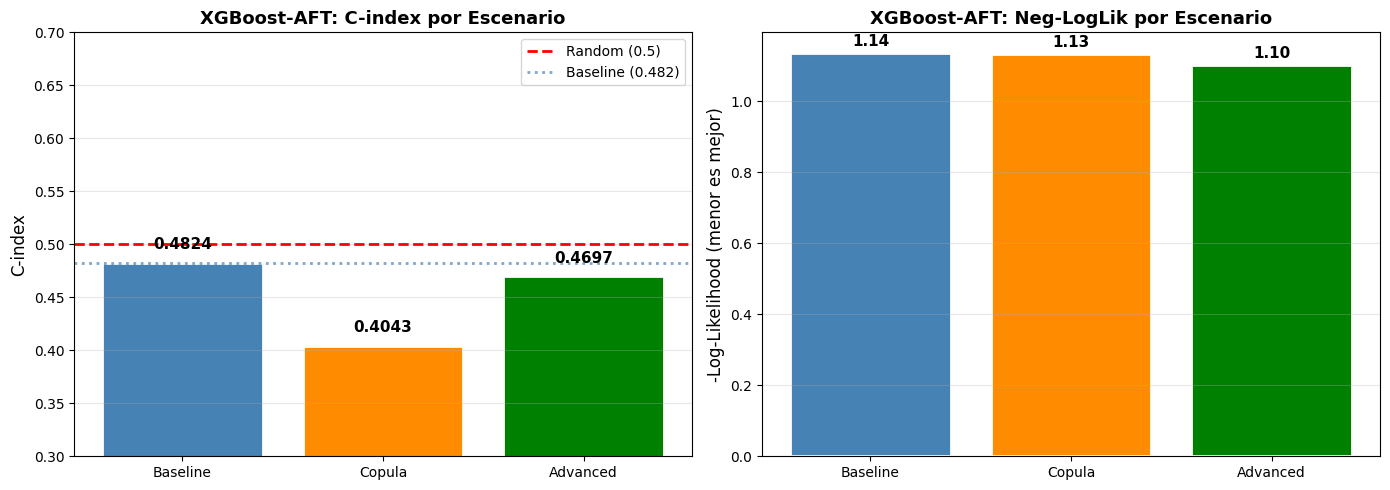


✅ Gráfico guardado: xgb_comparison.png


In [7]:
# ==============================================================================
# VISUALIZACIÓN
# ==============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenarios = results_df['scenario'].values
c_indices = results_df['c_index'].values
neg_logliks = results_df['neg_loglik'].values
colors = ['steelblue', 'darkorange', 'green']

# --- C-index ---
ax1 = axes[0]
bars1 = ax1.bar(range(len(scenarios)), c_indices, color=colors, edgecolor='white', linewidth=2)
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random (0.5)')
ax1.axhline(y=baseline_cindex, color='steelblue', linestyle=':', linewidth=2, alpha=0.7, label=f'Baseline ({baseline_cindex:.3f})')

for i, (bar, c_idx) in enumerate(zip(bars1, c_indices)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{c_idx:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xticks(range(len(scenarios)))
ax1.set_xticklabels(['Baseline', 'Copula', 'Advanced'], fontsize=10)
ax1.set_ylabel('C-index', fontsize=12)
ax1.set_title('XGBoost-AFT: C-index por Escenario', fontsize=13, fontweight='bold')
ax1.set_ylim(0.3, 0.7)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# --- Neg-LogLik ---
ax2 = axes[1]
bars2 = ax2.bar(range(len(scenarios)), neg_logliks, color=colors, edgecolor='white', linewidth=2)

for i, (bar, nll) in enumerate(zip(bars2, neg_logliks)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{nll:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xticks(range(len(scenarios)))
ax2.set_xticklabels(['Baseline', 'Copula', 'Advanced'], fontsize=10)
ax2.set_ylabel('-Log-Likelihood (menor es mejor)', fontsize=12)
ax2.set_title('XGBoost-AFT: Neg-LogLik por Escenario', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'xgb_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: xgb_comparison.png")

---
## 5. Guardar Resultados

In [8]:
# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================

# CSV
results_df.to_csv(OUTPUT_DIR / 'xgb_results.csv', index=False)
print("💾 Guardado: xgb_results.csv")

# JSON detallado
report = {
    "metadata": {
        "date": datetime.now().isoformat(),
        "model": "XGBoost-AFT",
        "methodology": "TSTR (Train on Synthetic, Test on Real)",
        "random_state": RANDOM_STATE
    },
    "test_set": {
        "n": int(len(dur_test)),
        "event_rate": float(evt_test.mean())
    },
    "xgb_params": xgb_params,
    "num_rounds": NUM_ROUNDS,
    "results": results,
    "best_model": {
        "scenario": str(best_model['scenario']),
        "c_index": float(best_model['c_index']),
        "delta_vs_baseline": float(best_model['delta_vs_baseline'])
    },
    "conclusion": {
        "synthetic_helps": bool(results_df[results_df['scenario'] != 'Baseline (Real Only)']['c_index'].max() > baseline_cindex),
        "best_synthetic_method": str(results_df.iloc[results_df['c_index'].idxmax()]['scenario'])
    }
}

with open(OUTPUT_DIR / 'xgb_evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print("💾 Guardado: xgb_evaluation_report.json")

# Guardar modelos
xgb_baseline.save_model(OUTPUT_DIR / 'xgb_baseline.json')
xgb_copula.save_model(OUTPUT_DIR / 'xgb_copula.json')
xgb_advanced.save_model(OUTPUT_DIR / 'xgb_advanced.json')
print("💾 Modelos guardados: xgb_*.json")

print("\n" + "="*50)
print("🎉 EVALUACIÓN XGBoost-AFT COMPLETADA")
print("="*50)

💾 Guardado: xgb_results.csv
💾 Guardado: xgb_evaluation_report.json
💾 Modelos guardados: xgb_*.json

🎉 EVALUACIÓN XGBoost-AFT COMPLETADA


---
## Resumen

### Resultados TSTR - XGBoost-AFT

| Escenario | n Train | C-index | -LogLik | Δ vs Baseline |
|-----------|---------|---------|---------|---------------|
| Baseline | 296 | ? | ? | — |
| Copula | 592 | ? | ? | ? |
| Advanced | 592 | ? | ? | ? |

### Interpretación

- **Δ > 0**: La data sintética mejora el modelo
- **Δ ≈ 0**: La data sintética no afecta
- **Δ < 0**: La data sintética degrada el modelo

### Siguiente Paso

**Prompt 10**: Conclusiones finales y reporte consolidado.

---